In [2]:
# !pip install catboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib.font_manager as fm 
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc' 
font = fm.FontProperties(fname=font_path).get_name() 
matplotlib.rc('font', family=font) 

In [5]:
# 데이터 로드
df = pd.read_csv('../eda/data/merged_data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39975 entries, 0 to 39974
Columns: 137 entries, 기준_년분기_코드 to 여성연령대_60_이상_직장_인구_수
dtypes: float64(132), int64(2), object(3)
memory usage: 41.8+ MB


In [7]:
df.describe()

,기준_년분기_코드,점포_수,유사_업종_점포_수,개업_률,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,당월_매출_금액,당월_매출_건수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
count,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,3.997500e+04,3.997500e+04,...,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000,39975.000000
mean,20220.096635,320.453959,353.995822,2.971897,11.176735,2.589829,9.794196,33.541864,1.553588e+10,5.749521e+05,...,27142.451857,26395.847330,19736.054484,9543.760350,223.790644,15057.239225,17365.139937,13473.701138,10014.440951,4391.736785
std,18.764856,624.817403,648.030094,2.385172,21.887316,2.001541,19.292389,71.256850,4.679056e+10,1.482439e+06,...,39941.977062,36960.317249,24219.922727,9600.950081,399.065330,22371.870231,24534.250632,16564.421275,11715.352615,4832.596737
min,20191.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.135000e+03,2.000000e+00,...,1169.000000,1978.000000,2704.000000,2245.000000,0.000000,635.000000,1180.000000,1674.000000,1663.000000,257.000000
25%,20203.000000,94.000000,105.000000,1.300000,2.000000,1.200000,2.000000,0.000000,1.197476e+09,1.463000e+04,...,5590.000000,5799.000000,5397.000000,3928.000000,0.000000,3138.000000,3795.000000,4042.000000,3856.000000,1695.000000
50%,20221.000000,161.000000,188.000000,2.600000,5.000000,2.300000,4.000000,4.000000,4.114511e+09,7.159500e+04,...,9123.000000,10094.000000,10122.000000,5924.000000,39.000000,5068.000000,6673.000000,6807.000000,5695.000000,2678.000000
75%,20234.000000,313.000000,357.000000,4.200000,12.000000,3.600000,10.000000,27.000000,1.251953e+10,3.641125e+05,...,24849.000000,24451.000000,18373.000000,10207.000000,209.000000,21296.000000,21114.000000,14062.000000,8866.000000,4775.000000
max,20252.000000,17827.000000,17845.000000,43.600000,773.000000,33.300000,554.000000,688.000000,1.399137e+12,2.716973e+07,...,204697.000000,188865.000000,116356.000000,51339.000000,1679.000000,114671.000000,124729.000000,86333.000000,63848.000000,26816.000000


In [8]:
# 입력-타겟 데이터 분리
X = df.drop('폐업_률', axis=1)
y = df['폐업_률']

In [9]:
# 범주형 데이터 인코딩
from sklearn.preprocessing import OneHotEncoder

# 범주형 컬럼 찾기
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X[categorical_cols])

# 인코딩 결과를 DataFrame으로 변환
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)

# 숫자 변수 + 인코딩된 범주 변수 합치기
X_encoded = pd.concat([X[numerical_cols], encoded_df], axis=1)

In [10]:
# 학습-검증 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, random_state=42)

In [25]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델 생성
model = CatBoostRegressor(
    iterations=1000,          # 최대 반복 횟수
    learning_rate=0.1,        # 학습률
    depth=6,                  # 트리 깊이
    eval_metric='RMSE',       # 평가 지표
    early_stopping_rounds=50, # 성능 개선 없을 시 조기 종료
    verbose=100,              # 100번마다 로그 출력
    use_best_model=True
)

# 모델 학습
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# 예측
y_pred = model.predict(X_valid)

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


0:	learn: 1.8753919	test: 1.9160165	best: 1.9160165 (0)	total: 18.7ms	remaining: 18.7s
100:	learn: 0.2522215	test: 0.3484266	best: 0.3484266 (100)	total: 1.72s	remaining: 15.3s
200:	learn: 0.1371945	test: 0.2827709	best: 0.2827709 (200)	total: 3.41s	remaining: 13.6s
300:	learn: 0.1052661	test: 0.2720823	best: 0.2718815 (296)	total: 5.11s	remaining: 11.9s
400:	learn: 0.0883731	test: 0.2676441	best: 0.2676441 (400)	total: 6.73s	remaining: 10.1s
500:	learn: 0.0787931	test: 0.2649766	best: 0.2649766 (500)	total: 8.57s	remaining: 8.53s
600:	learn: 0.0711588	test: 0.2629248	best: 0.2628856 (595)	total: 10.7s	remaining: 7.09s
700:	learn: 0.0658585	test: 0.2619715	best: 0.2619715 (700)	total: 12.6s	remaining: 5.39s
800:	learn: 0.0616112	test: 0.2611395	best: 0.2610229 (798)	total: 16.5s	remaining: 4.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.260732796
bestIteration = 836

Shrink model to first 837 iterations.
RMSE: 0.2607
MSE: 0.0680
MAE: 0.0599
R2: 0.9835


C:\Users\kouls\AppData\Local\Temp\ipykernel_39360\2385225164.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='viridis')


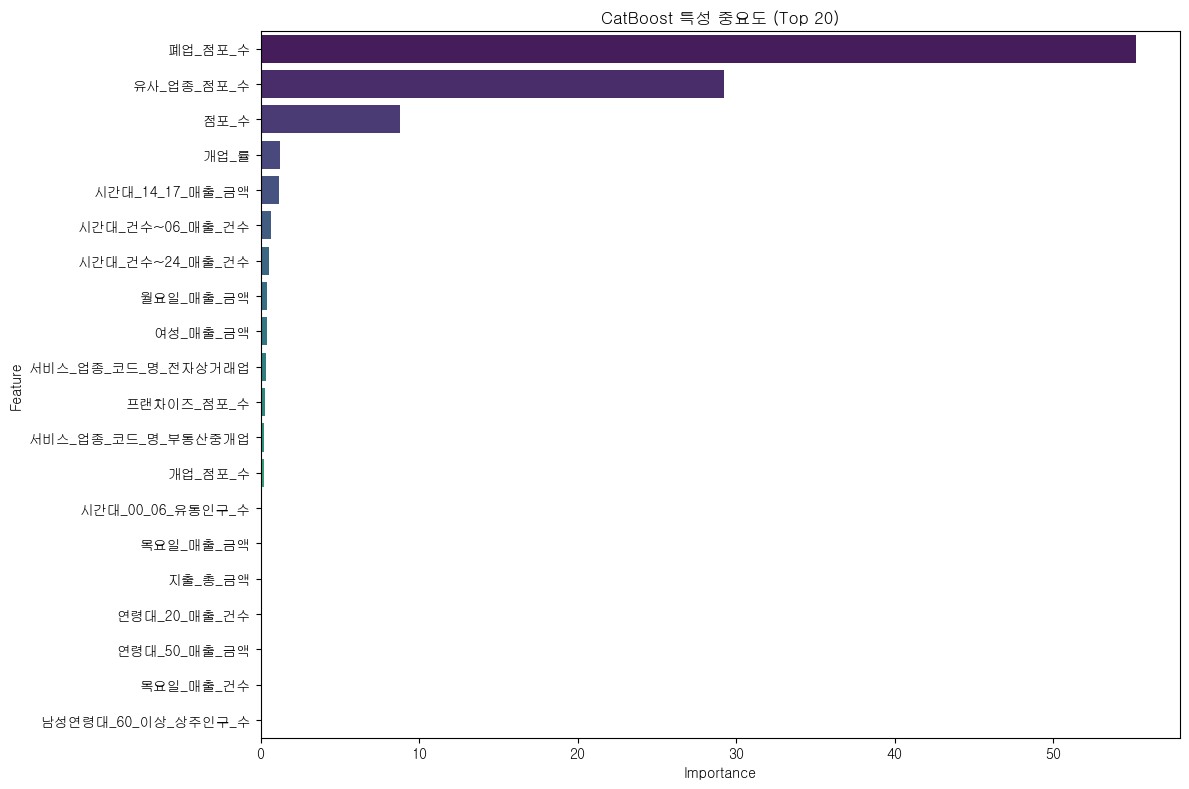

In [12]:
# 특성 중요도 시각화
feature_importances = model.get_feature_importance()
feature_names = X_encoded.columns

# 데이터프레임으로 정리
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 상위 20개 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('CatBoost 특성 중요도 (Top 20)')
plt.tight_layout()
plt.show()

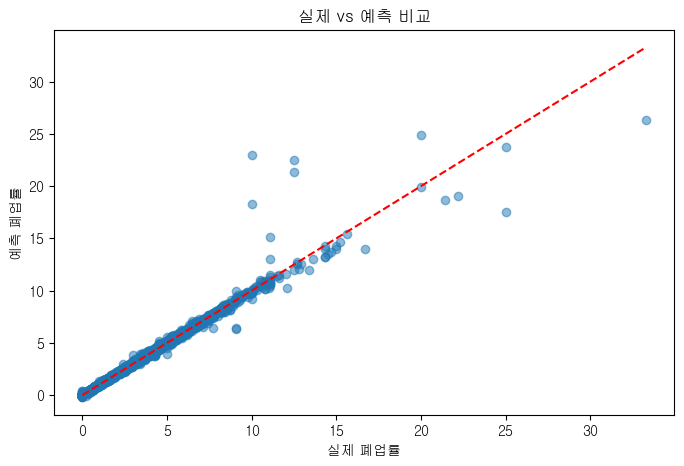

In [13]:
# 실제값과 예측값 비교
plt.figure(figsize=(8, 5))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--') 
plt.xlabel("실제 폐업률")
plt.ylabel("예측 폐업률")
plt.title("실제 vs 예측 비교")
plt.show()

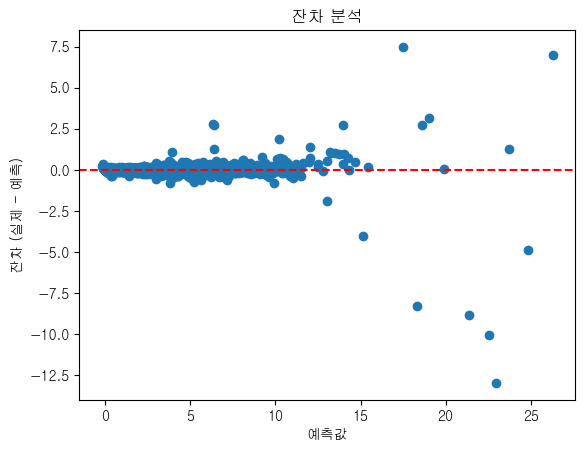

In [14]:
# 잔차 분석 확인
residuals = y_valid - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('예측값')
plt.ylabel('잔차 (실제 - 예측)')
plt.title('잔차 분석')
plt.show()

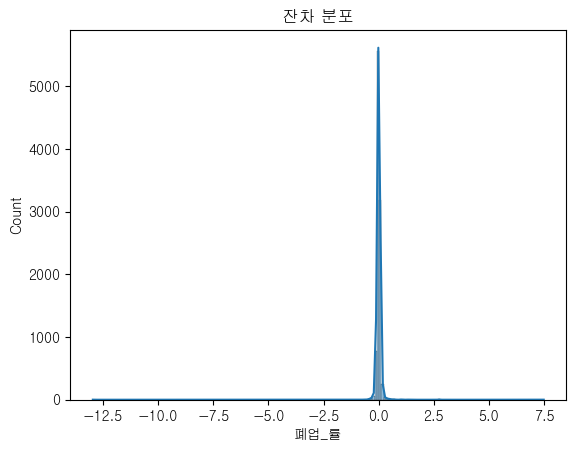

In [15]:
# 잔차 분포 확인
sns.histplot(residuals, kde=True)
plt.title('잔차 분포')
plt.show()

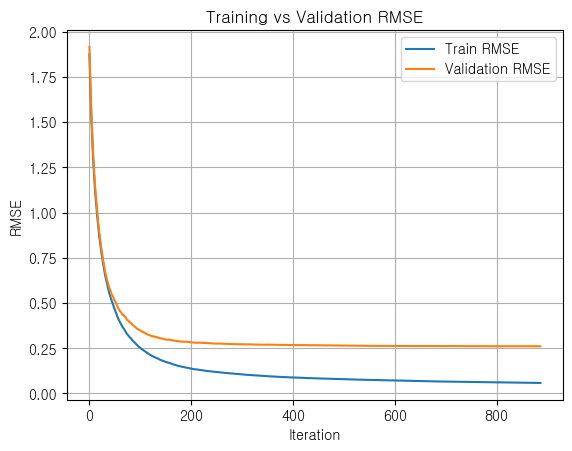

In [26]:
# 학습 곡선 시각화
evals_result = model.get_evals_result()
plt.plot(evals_result['learn']['RMSE'], label='Train RMSE')
plt.plot(evals_result['validation']['RMSE'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# KFold
from sklearn.model_selection import KFold

# KFold 객체 생성
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for train_index, val_index in kf.split(X_encoded):
    X_train_fold, X_val_fold = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # 모델 생성
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        eval_metric='RMSE',
        early_stopping_rounds=50,
        verbose=False
    )

    # 모델 학습
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

    preds = model.predict(X_val_fold)

    # 성능 평가
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mse = mean_squared_error(y_valid, y_pred)
    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 0.2607
MSE: 0.0680
MAE: 0.0599
R2: 0.9835


In [18]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 설정할 파라미터
params = {
    'depth': range(1, 10, 1),            
    'learning_rate': np.arange(0.01, 0.1, 0.01),    
    'iterations': range(500, 1000, 100)       
}

# CatBoost 모델 생성
model = CatBoostRegressor(verbose=0)

# GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring='neg_root_mean_squared_error',
    cv=3   
)

# 모델 훈련
grid.fit(X_train, y_train)

# 결과 
print('최적의 파라미터:', grid.best_params_) 
print('최적화된 모델 객체:', grid.best_estimator_) 
print('최적화된 점수:', grid.best_score_) 

KeyboardInterrupt: 